In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
%cd /gdrive/My Drive/AN2DL/ExerciseSession5v2

/gdrive/My Drive/AN2DL/ExerciseSession5v2


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.12.0


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
unzip = False
if unzip:
    !unzip training_data.zip
    !unzip processed_training_labels.zip

Archive:  training_data.zip
replace training_data/aachen_000000_000019_leftImg8bit.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  processed_training_labels.zip
replace processed_training_labels/zurich_000002_000019_gtFine_color.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
category_map = {
    0: 0,  # unlabelled
    1: 0,  # static
    2: 0,  # ground
    3: 1,  # road
    4: 1,  # sidewalk
    5: 1,  # parking
    6: 1,  # rail track
    7: 2,  # building
    8: 2,  # wall
    9: 2,  # fence
    10: 2, # guard rail
    11: 2, # bridge
    12: 2, # tunnel
    13: 3, # pole
    14: 3, # polegroup
    15: 3, # traffic light
    16: 3, # traffic sign
    17: 4, # vegetation
    18: 4, # terrain
    19: 5, # sky
    20: 6, # person
    21: 6, # rider
    22: 7, # car
    23: 7, # truck
    24: 7, # bus
    25: 7, # caravan
    26: 7, # trailer
    27: 7, # train
    28: 7, # motorcycle
    29: 7, # bicycle
    30: 7  # license plate 
}
num_classes = len(category_map.keys())

In [8]:
data = []
for file in np.sort(os.listdir('training_data')):
    img = np.array(Image.open('training_data/'+file))
    data.append(img)
data = np.array(data)
data.shape

(2975, 128, 256, 3)

In [9]:
labels = []
for file in np.sort(os.listdir('processed_training_labels')):
    img = np.array(Image.open('processed_training_labels/'+file))
    labels.append(np.expand_dims(img,axis=-1))
labels = np.array(labels)
labels.shape

(2975, 128, 256, 1)

In [10]:
X = data / 255.
y = labels

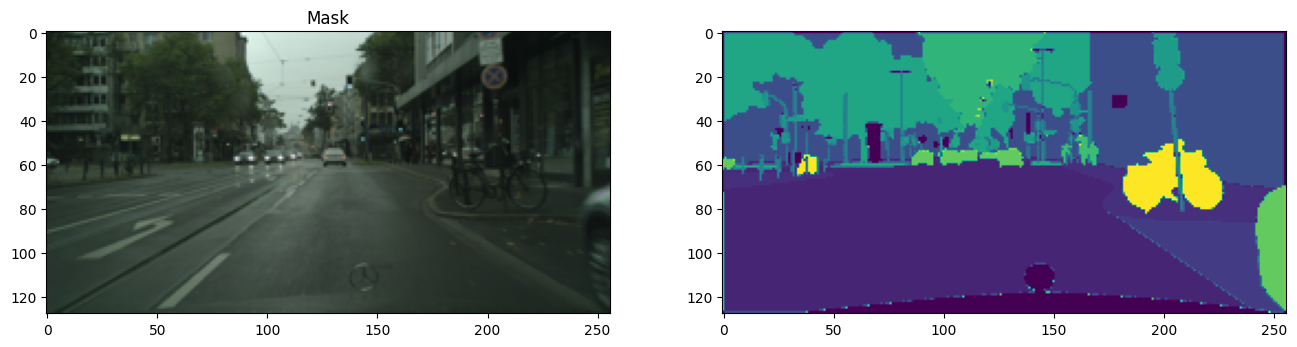

In [11]:
def plot_pairs(data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    fig, axes = plt.subplots(1, 2, figsize=(16,4))
    axes[0].set_title("Image")
    axes[0].imshow(data[index])
    axes[0].set_title("Mask")
    axes[1].imshow(np.squeeze(labels[index]))
    plt.show()
plot_pairs(X,y)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=seed)

In [13]:
input_shape = X_train.shape[1:]
input_shape

(128, 256, 3)

In [14]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', name=''):
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'activation1')(x)
    x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)
    x = tfkl.Activation(activation, name=name+'activation2')(x)
    return x

In [15]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.2, seed=seed)(d1)

    # Second Downsampling
    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.2, seed=seed)(d2)

    # Third Downsampling
    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.2, seed=seed)(d3)

    # Forth Downsampling
    down_block_4 = unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)
    d4 = tfkl.Dropout(0.2, seed=seed)(d4)

    # Bottleneck
    bottleneck = unet_block(d4, 512)

    # First Upsampling
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Dropout(0.2, seed=seed)(u1)
    u1 = tfkl.Concatenate()([u1,down_block_4])
    u1 = unet_block(u1, 256, name='up_block1_')

    # Second Upsampling
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Dropout(0.2, seed=seed)(u2)
    u2 = tfkl.Concatenate()([u2,down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    # Third Upsampling
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Dropout(0.2, seed=seed)(u3)
    u3 = tfkl.Concatenate()([u3,down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    # Forth Upsampling
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Dropout(0.2, seed=seed)(u4)
    u4 = tfkl.Concatenate()([u4,down_block_1])
    u4 = unet_block(u4, 32, name='up_block4_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=3, padding='same', activation="softmax", name='output_layer')(u4)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 down_block1_conv1 (Conv2D)     (None, 128, 256, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 down_block1_bn1 (BatchNormaliz  (None, 128, 256, 32  128        ['down_block1_conv1[0][0]']      
 ation)                         )                                                             

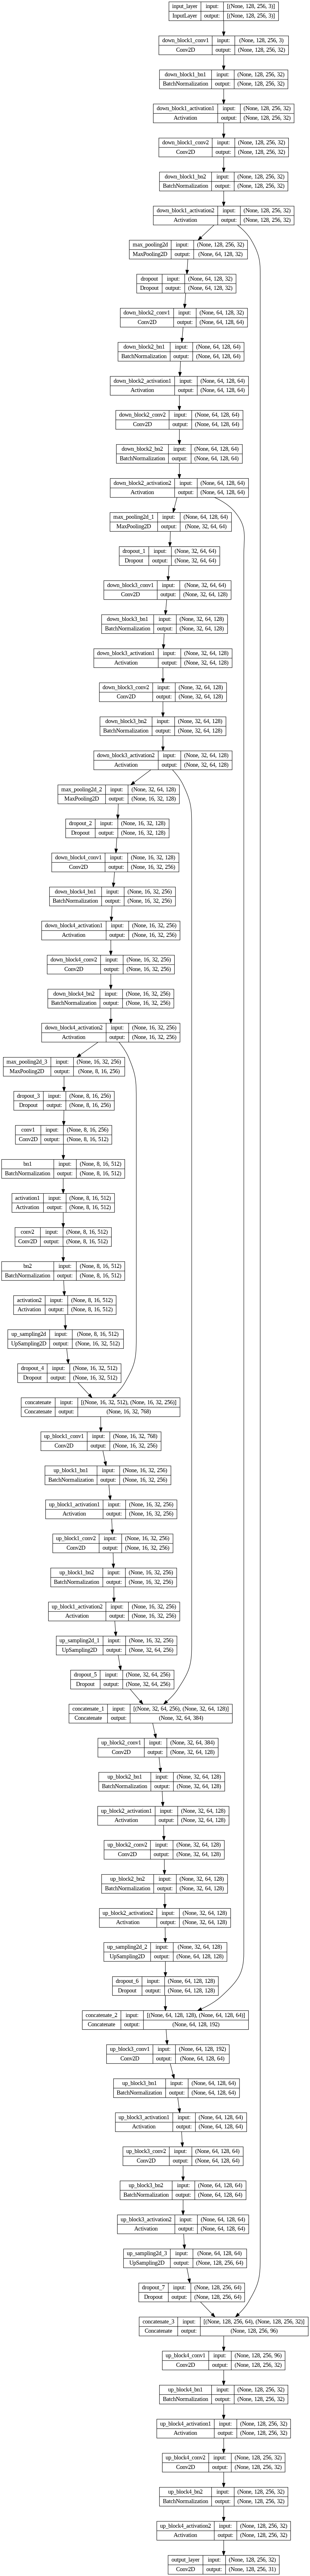

In [16]:
model = get_unet_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True)

In [35]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None,
               **kwargs):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "num_classes": self.num_classes}

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label
    
    def on_epoch_end(self, epoch, logs=None):
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16,4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Original Mask")
        axes[1].imshow(np.squeeze(y_pred))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [18]:
learning_rate = 1e-3
batch_size = 16
epochs = 1000
model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = tfk.optimizers.Adam(learning_rate), 
    metrics = [
        "accuracy", 
        UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")
        ]
    )

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience = 10, restore_best_weights = True)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))

In [20]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    epochs = epochs, 
    batch_size = batch_size, 
    validation_data = (X_val, y_val), 
    callbacks=[early_stopping, viz_callback],
    verbose=2
    )

Output hidden; open in https://colab.research.google.com to view.

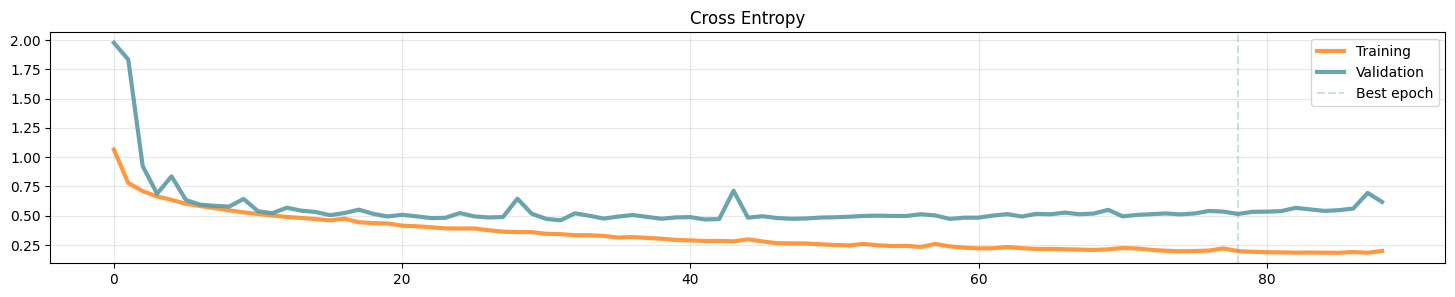

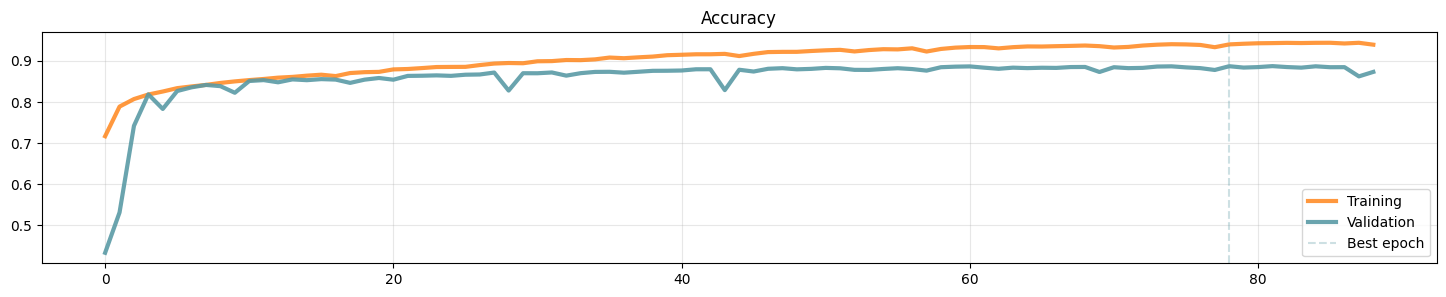

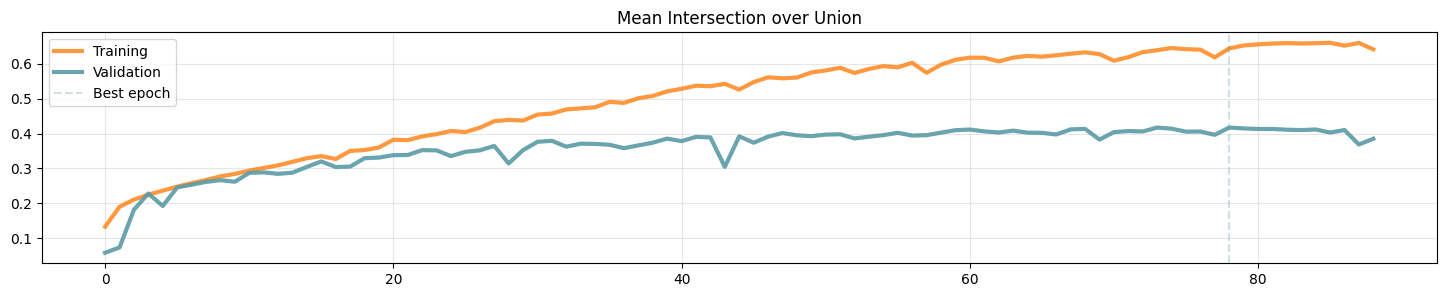

In [21]:
best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
model.save('UNet')
del model

In [36]:
model = tfk.models.load_model('UNet', custom_objects={ 'UpdatedMeanIoU': UpdatedMeanIoU})

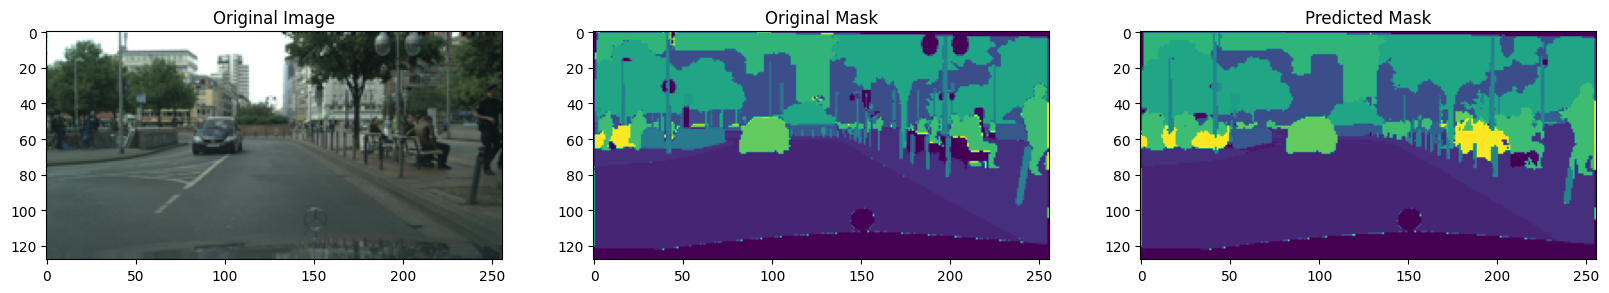

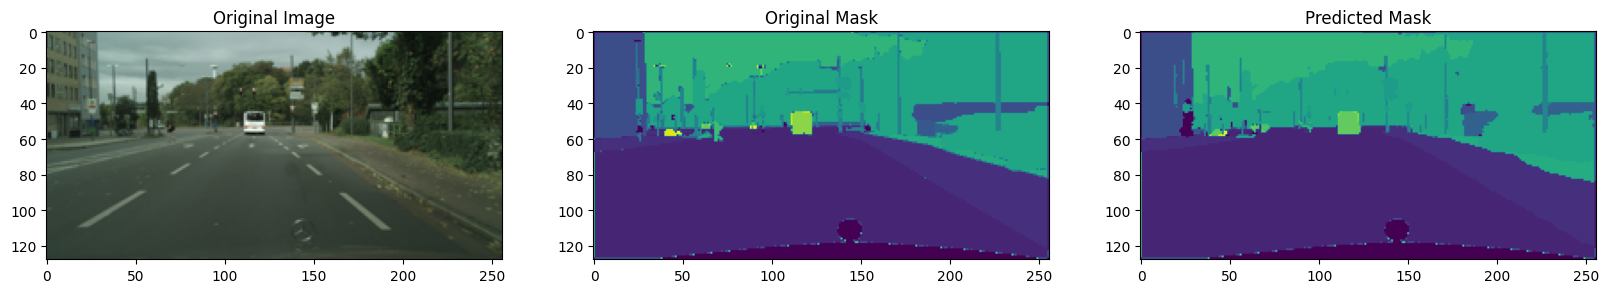

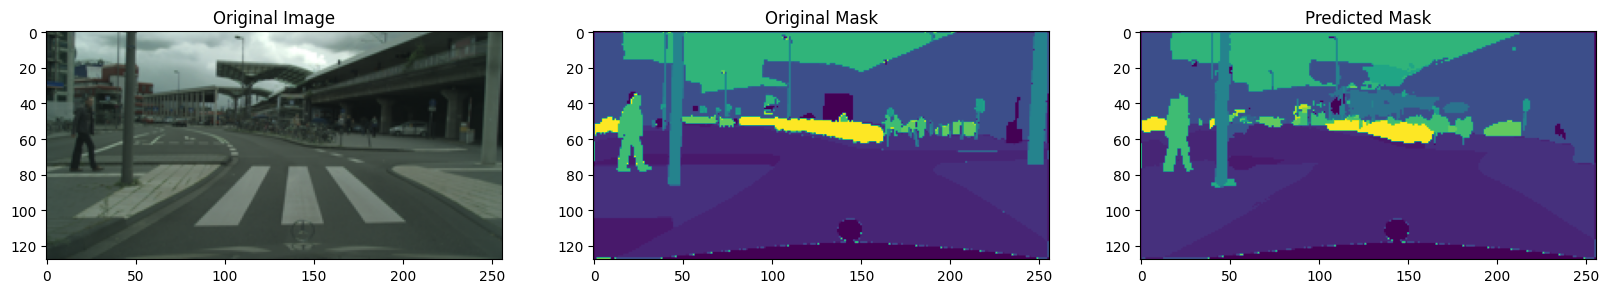

In [37]:
def plot_triptychs(model, data, labels, index=None):
    if index == None:
        index = np.random.randint(0,len(data))
    pred = model.predict(np.expand_dims(data[index], axis=0), verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (128, 256, 1))
    fig, axes = plt.subplots(1, 3, figsize=(20,4))
    axes[0].set_title("Original Image")
    axes[0].imshow(data[index])
    axes[1].set_title("Original Mask")
    axes[1].imshow(np.squeeze(labels[index]))
    axes[2].set_title("Predicted Mask")
    axes[2].imshow(np.squeeze(pred))
    plt.show()
plot_triptychs(model,X_val,y_val)
plot_triptychs(model,X_val,y_val)
plot_triptychs(model,X_val,y_val)